# Homework 3: Pandas, Regular Expressions, Visualizations

## Due Date: Fri 4/22, 11:59 pm KST

**Collaboration Policy:** You may talk with others about the homework, but we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following line.

**Collaborators**: *list collaborators here (if applicable)*

### Score Breakdown

Question | Points
--- | ---
Question 1a | 2
Question 1b | 1
Question 1c | 2
Question 2 | 2
Question 3 | 1
Question 4 | 2
Question 5a | 1
Question 5b | 2
Question 5c | 2
Question 6a | 1
Question 6b | 1
Question 6c | 1
Question 6d | 2
Question 6e | 2
Total | 22

### Initialize your environment

This cell should run without error.

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
from pprint import pprint # to get a more easily-readable view.

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

Some common utilities.

In [ ]:
def utils_head(filename, lines=5):
    """
    Returns the first few lines of a file.
    
    filename: the name of the file to open
    lines: the number of lines to include
    
    return: A list of the first few lines from the file.
    """
    from itertools import islice
    with open(filename, "r") as f:
        return list(islice(f, lines))

# Part 1: Bike Sharing

The data we are exploring is collected from a bike sharing system in Washington D.C.

The variables in this data frame are defined as:

Variable       | Description
-------------- | ------------------------------------------------------------------
instant | record index
dteday | date
season | 1. spring <br> 2. summer <br> 3. fall <br> 4. winter
yr | year (0: 2011, 1:2012)
mnth | month ( 1 to 12)
hr | hour (0 to 23)
holiday | whether day is holiday or not
weekday | day of the week
workingday | if day is neither weekend nor holiday
weathersit | 1. clear or partly cloudy <br> 2. mist and clouds <br> 3. light snow or rain <br> 4. heavy rain or snow
temp | normalized temperature in Celsius (divided by 41)
atemp | normalized "feels-like" temperature in Celsius (divided by 50)
hum | normalized percent humidity (divided by 100)
windspeed| normalized wind speed (divided by 67)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes including casual and registered  

## Mount your Google Drive
When you run a code cell, Colab executes it on a temporary cloud instance.  Every time you open the notebook, you will be assigned a different machine.  All compute state and files saved on the previous machine will be lost.  Therefore, you may need to re-download datasets or rerun code after a reset. Here, you can mount your Google drive to the temporary cloud instance's local filesystem using the following code snippet and save files under the specified directory (note that you will have to provide permission every time you run this).

In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# now you can see files
!echo -e "\nNumber of Google drive files in /content/drive/My Drive/:"
!ls -l "/content/drive/My Drive/" | wc -l
# by the way, you can run any linux command by putting a ! at the start of the line

# by default everything gets executed and saved in /content/
!echo -e "\nCurrent directory:"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Number of Google drive files in /content/drive/My Drive/:
40

Current directory:
/content


In [ ]:
workspace_path = '/content/drive/MyDrive/Lectures/COSE471/hw/hw3/'  # Change this path!
for line in utils_head(workspace_path+'bikeshare.txt'):
    print(line, end="")

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13


### Loading the data

The following code loads the data into a Pandas DataFrame.

In [ ]:
bike = pd.read_csv(workspace_path+'bikeshare.txt')
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Below, we show the shape of the file. You should see that the size of the DataFrame matches the number of lines in the file, minus the header row.

In [ ]:
bike.shape

(17379, 17)

## Question 1: Data Preparation
A few of the variables that are numeric/integer actually encode categorical data. These include `holiday`, `weekday`, `workingday`, and `weathersit`. In the following problem, we will convert these four variables to strings specifying the categories. In particular, use 3-letter labels (`Sun`, `Mon`, `Tue`, `Wed`, `Thu`, `Fri`, and `Sat`) for `weekday`. You may simply use `yes`/`no` for `holiday` and `workingday`. 

In this exercise we will *mutate* the data frame, **overwriting the corresponding variables in the data frame.** However, our notebook will effectively document this in-place data transformation for future readers. Make sure to leave the underlying datafile `bikeshare.txt` unmodified.

### Question 1a


Decode the `holiday`, `weekday`, `workingday`, and `weathersit` fields:

1. holiday: Convert to `yes` and `no`. **Hint**: There are fewer holidays...
1. weekday: It turns out that Monday is the day with the most holidays.  Mutate the `'weekday'` column to use the 3-letter label (`'Sun'`, `'Mon'`, `'Tue'`, `'Wed'`, `'Thu'`, `'Fri'`, and `'Sat'`) instead of its current numerical values. Note `0` corresponds to `Sun`, `1` to `Mon` and so on.
1. workingday: Convert to `yes` and `no`.
1. weathersit: You should replace each value with one of `Clear`, `Mist`, `Light`, or `Heavy`.

**Note:** If you want to revert changes, run the cell that reloads the csv.

**Hint:**  One simple approach is to use the [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) method of the pandas DataFrame class. We haven't discussed how to do this so you'll need to look at the documentation. The most concise way is with the approach described in the documentation as ``nested-dictonaries``, though there are many possible solutions. E.g. for a DataFrame nested dictionaries, e.g., `{'a': {'b': np.nan}}`, are read as follows: look in column `a` for the value `b` and replace it with `NaN`.

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
factor_dict = {
    ...
}
# -----------------------
# END YOUR CODE
bike.replace(factor_dict, inplace=True)
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,no,Sat,no,Clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,no,Sat,no,Clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,no,Sat,no,Clear,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
assert isinstance(bike, pd.DataFrame) == True
assert bike['holiday'].dtype == np.dtype('O')
assert list(bike['holiday'].iloc[370:375]) == ['no', 'no', 'yes', 'yes', 'yes']
assert bike['weekday'].dtype == np.dtype('O')
assert bike['workingday'].dtype == np.dtype('O')
assert bike['weathersit'].dtype == np.dtype('O')
assert bike.shape == (17379, 17) or bike.shape == (17379, 18)
assert list(bike['weekday'].iloc[::2000]) == ['Sat', 'Tue', 'Mon', 'Mon', 'Mon', 'Sun', 'Sun', 'Sat', 'Sun']

print('Passed all unit tests!')

Passed all unit tests!


### Question 1b

How many entries in the data correspond to holidays?  Set the variable `num_holidays` to this value.

**Hint:** ``value_counts``

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [ ]:
num_holidays = ...

In [ ]:
assert num_holidays == 500
assert 1 <= num_holidays <= 10000

print('Passed all unit tests!')

Passed all unit tests!


### Question 1c (Computing Daily Total Counts)

The granularity of this data is at the hourly level.  However, for some of the analysis we will also want to compute daily statistics.  In particular, in the next few questions we will be analyzing the daily number of registered and unregistered users.

Construct a data frame named `daily_counts` indexed by `dteday` with the following columns:
* `casual`: total number of casual riders for each day
* `registered`: total number of registered riders for each day
* `workingday`: whether that day is a working day or not (`yes` or `no`)

**Hint**: `groupby` and `agg`. For the `agg` method, please check the [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html) for examples on applying different aggregations per column. If you use the capability to do different aggregations by column, you can do this task with a single call to `groupby` and `agg`. For the `workingday` column we can take any of the values since we are grouping by the day, thus the value will be the same within each group. Take a look at the `'first'` or `'last'` aggregation functions.

<!--
BEGIN QUESTION
name: q1c
points: 2
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
daily_counts = ...
# -----------------------
# END YOUR CODE
daily_counts.head()

,casual,registered,workingday
dteday,,,
2011-01-01,331,654,no
2011-01-02,131,670,no
2011-01-03,120,1229,yes
2011-01-04,108,1454,yes
2011-01-05,82,1518,yes


In [ ]:
assert np.round(daily_counts['casual'].mean()) == 848.0
assert np.round(daily_counts['casual'].var()) == 471450.0
assert np.round(daily_counts['registered'].mean()) == 3656.0
assert np.round(daily_counts['registered'].var()) == 2434400.0
assert sorted(list(daily_counts['workingday'].value_counts())) == [231, 500]

print('Passed all unit tests!')

Passed all unit tests!


# Part 2: Trump and Tweets

In this part, we will work with Twitter data in order to analyze Donald Trump's tweets.

Let's load data into our notebook. Run the cell below to read tweets from the json file into a list named `all_tweets`.

In [ ]:
with open(workspace_path+"hw3-realdonaldtrump_tweets.json", "r") as f:
    all_tweets = json.load(f)

Here is what a typical tweet from `all_tweets` looks like:

In [ ]:
pprint(all_tweets[-1])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Oct 16 18:40:18 +0000 2018',
 'display_text_range': [0, 174],
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 52115,
 'favorited': False,
 'full_text': 'Just spoke with the Crown Prince of Saudi Arabia who totally '
              'denied any knowledge of what took place in their Turkish '
              'Consulate. He was with Secretary of State Mike Pompeo...',
 'geo': None,
 'id': 1052268011900555265,
 'id_str': '1052268011900555265',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 13493,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" '
           'rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'user': {'contributors_enabled': False,
  

## Question 2

Construct a DataFrame called `trump` containing data from all the tweets stored in `all_tweets`. The index of the DataFrame should be the `ID` of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting DataFrame should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

<!--
BEGIN QUESTION
name: q1
points: 2
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
trump = ...
# -----------------------
# END YOUR CODE
trump.head()

,time,source,text,retweet_count
690171032150237184,2016-01-21 13:56:11+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>","Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57+00:00,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


In [ ]:
assert isinstance(trump, pd.DataFrame)
assert 10000 < trump.shape[0] < 11000
assert trump.shape[1] >= 4
assert 831846101179314177 in trump.index
assert all(col in trump.columns for col in ['time', 'source', 'text', 'retweet_count'])
assert np.sometrue([('Twitter for iPhone' in s) for s in trump['source'].unique()])
assert trump['text'].dtype == np.dtype('O')
assert trump['retweet_count'].dtype == np.dtype('int64')
assert 753063644578144260 in trump.index

print('Passed all unit tests!')

Passed all unit tests!


In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [ ]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

## Question 3

Notice how sources like "Twitter for Android" or "Instagram" are surrounded by HTML tags. In the cell below, clean up the `source` field by removing the HTML tags from each `source` entry.

**Hints:** 
* Use `trump['source'].str.replace` along with a regular expression.
* You may find it helpful to experiment with regular expressions at [regex101.com](https://regex101.com/).

<!--
BEGIN QUESTION
name: q2
points: 1
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
trump['source'] = ...
# -----------------------
# END YOUR CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
assert set(trump['source'].unique()) == set(['Twitter for Android', 'Twitter for iPhone', 'Twitter Web Client',
       'Mobile Web (M5)', 'Instagram', 'Twitter for iPad', 'Media Studio',
       'Periscope', 'Twitter Ads', 'Twitter Media Studio'])

print('Passed all unit tests!')

Passed all unit tests!


In the following plot, we see that there are two device types that are more commonly used than others.

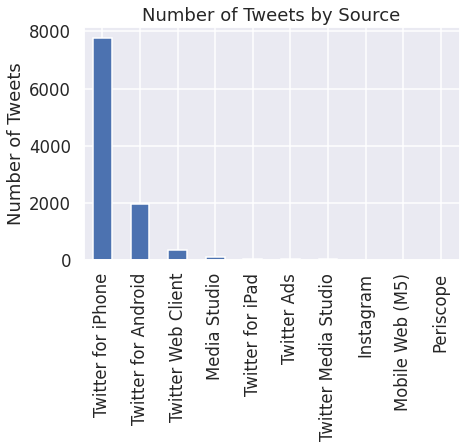

In [ ]:
plt.figure(figsize=(6, 4))
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets by Source");

## Question 4

Now that we have cleaned up the `source` field, let's now look at which device Trump has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [ ]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

Now, use `sns.distplot` to overlay the distributions of Trump's 2 most frequently used web technologies over the years.

<!--
BEGIN QUESTION
name: q3
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


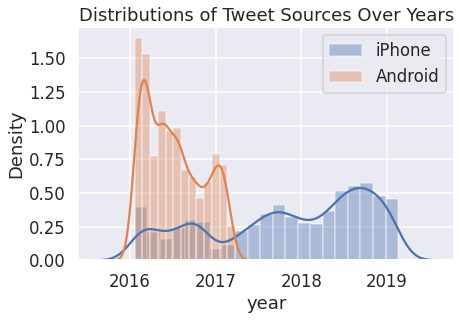

In [ ]:
# BEGIN YOUR CODE
# -----------------------
top_devices = ...
for device in top_devices:
  sns.distplot(...)
# -----------------------
# END YOUR CODE

## Question 5


Is there a difference between Trump's tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android device come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets).

In [ ]:
for tweet in all_tweets[:3]:
    print(tweet['created_at'])

Wed Oct 12 14:00:48 +0000 2016
Wed Oct 12 13:46:43 +0000 2016
Wed Oct 12 12:59:05 +0000 2016


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [ ]:
trump['est_time'] = (
    trump['time'].dt.tz_convert("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,year,est_time
690171032150237184,2016-01-21 13:56:11+00:00,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016.054645,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39+00:00,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54+00:00,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26+00:00,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57+00:00,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00


### Question 5a

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

* **Hint:** See the cell above for an example of working with [dt accessors](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dt-accessors).

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
trump['hour'] = ...
# -----------------------
# END YOUR CODE

In [ ]:
assert np.isclose(trump.loc[690171032150237184]['hour'], 8.93639) == True

print('Passed all unit tests!')

Passed all unit tests!


### Question 5b

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.

<!--
BEGIN QUESTION
name: q4b
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


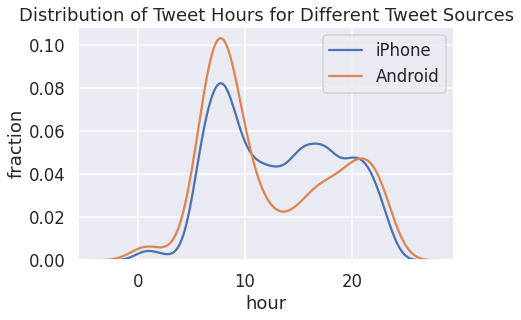

In [ ]:
# BEGIN YOUR CODE
# -----------------------
top_devices = ...
for device in top_devices:
  sns.distplot(...)
# -----------------------
# END YOUR CODE

### Question 5c

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Let's see if this information significantly changes our plot. Create a figure similar to your figure from question 5b, but this time, only use tweets that were tweeted before 2017.

<!--
BEGIN QUESTION
name: q4c
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


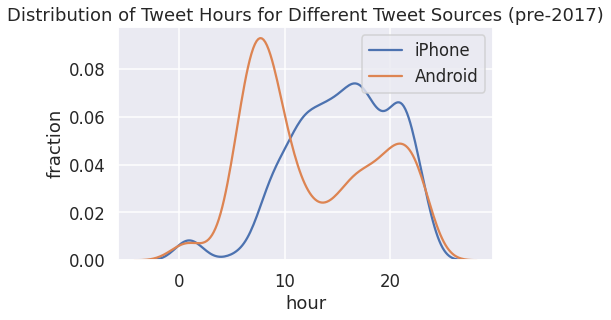

In [ ]:
# BEGIN YOUR CODE
# -----------------------
...
# -----------------------
# END YOUR CODE

### Question 5d

During the campaign, it was theorized that Donald Trump's tweets from Android devices were written by him personally, and the tweets from iPhones were from his staff. Does your figure give support to this theory? What kinds of additional analysis could help support or reject this claim?

<!--
BEGIN QUESTION
name: q4d
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

Answer: `your answer here...`

---
# Part 3: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [ ]:
print(''.join(open(workspace_path+"vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



## Question 6

As you can see, the lexicon contains emojis too! Each row contains a word and the *polarity* of that word, measuring how positive or negative the word is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

### Question 6a

Read in the lexicon into a DataFrame called `sent`. The index of the DataFrame should be the words in the lexicon. `sent` should have one column named `polarity`, storing the polarity of each word.

* **Hint:** The `pd.read_csv` function may help here. 

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
sent = ...
# -----------------------
# END YOUR CODE
sent.head()

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [ ]:
assert np.allclose(sent['polarity'].head(), [-1.5, -0.4, -1.5, -0.4, -0.7]) == True
assert list(sent.index[5000:5005]) == ['paranoids', 'pardon', 'pardoned', 'pardoning', 'pardons']

print('Passed all unit tests!')

Passed all unit tests!


### Question 6b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DataFrame to be the lowercased text of each tweet.

<!--
BEGIN QUESTION
name: q5b
points: 1
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
trump['text'] = ...
# -----------------------
# END YOUR CODE
trump.head()

,time,source,text,retweet_count,year,est_time,hour
690171032150237184,2016-01-21 13:56:11+00:00,Twitter for Android,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",1059,2016.054645,2016-01-21 08:56:11-05:00,8.936389
690171403388104704,2016-01-21 13:57:39+00:00,Twitter for Android,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00,8.960833
690173226341691392,2016-01-21 14:04:54+00:00,Twitter for Android,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00,9.081667
690176882055114758,2016-01-21 14:19:26+00:00,Twitter for Android,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00,9.323889
690180284189310976,2016-01-21 14:32:57+00:00,Twitter for Android,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00,9.549167


In [ ]:
assert trump['text'].loc[884740553040175104] == 'working hard to get the olympics for the united states (l.a.). stay tuned!'

print('Passed all unit tests!')

Passed all unit tests!


### Question 6c

Now, let's get rid of punctuation since it will cause us to fail to match words. Create a new column called `no_punc` in the `trump` DataFrame to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be **any character that isn't a Unicode word character or a whitespace character**. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

<!--
BEGIN QUESTION
name: q5c
points: 1
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
punct_re = r''  # Save your regex in punct_re
trump['no_punc'] = ...
# -----------------------
# END YOUR CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
assert re.search(punct_re, 'this') == None
assert re.search(punct_re, 'this is not ok.') != None
assert re.search(punct_re, 'this#is#ok') != None
assert re.search(punct_re, 'this^is ok') != None

print('Passed all unit tests!')

Passed all unit tests!


### Question 6d

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that your DataFrame may look different from the one above.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the `trump` DataFrame, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.

<!--
BEGIN QUESTION
name: q5d
points: 2
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
tidy_format = ...
# -----------------------
# END YOUR CODE
tidy_format.head()

,num,word
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t


In [ ]:
assert tidy_format.loc[894661651760377856].shape == (27,2)
assert ' '.join(list(tidy_format.loc[894661651760377856]['word'])) == 'i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there'

print('Passed all unit tests!')

Passed all unit tests!


### Question 6e

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hints:** 
* You will need to merge the `tidy_format` and `sent` tables and group the final answer.
* If certain words are not found in the `sent` table, set their polarities to 0.

<!--
BEGIN QUESTION
name: q5e
points: 2
-->

In [ ]:
# BEGIN YOUR CODE
# -----------------------
trump['polarity'] = ...
# -----------------------
# END YOUR CODE
trump[['text', 'polarity']].head()

,text,polarity
690171032150237184,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",0.0
690171403388104704,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",-2.6
690173226341691392,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,-6.0
690176882055114758,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",4.3
690180284189310976,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,-2.6


In [ ]:
assert np.allclose(trump.loc[744701872456536064, 'polarity'], 8.4)
assert np.allclose(trump.loc[745304731346702336, 'polarity'], 2.5)
assert np.allclose(trump.loc[744519497764184064, 'polarity'], 1.7)
assert np.allclose(trump.loc[894661651760377856, 'polarity'], 0.2)
assert np.allclose(trump.loc[894620077634592769, 'polarity'], 5.4)

print('Passed all unit tests!')

Passed all unit tests!


Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [ ]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s southern....

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   ...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of an

In [ ]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new

---

Now, let's try looking at the distributions of sentiments for tweets containing certain keywords.

In the cell below, we create a single plot showing both the distribution of tweet sentiments for tweets containing `nytimes`, as well as the distribution of tweet sentiments for tweets containing `fox`. Here, we notice that the president appears to say more positive things about Fox than the New York Times.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


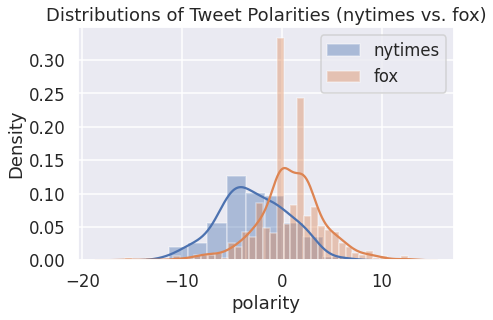

In [ ]:
sns.distplot(trump[trump['text'].str.lower().str.contains("nytimes")]['polarity'], label = 'nytimes')
sns.distplot(trump[trump['text'].str.lower().str.contains("fox")]['polarity'], label = 'fox')
plt.title('Distributions of Tweet Polarities (nytimes vs. fox)')
plt.legend();

### Congratulations! You have completed HW3.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.,

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

**Please save before submitting!**

<!-- EXPECT 5 EXPORTED QUESTIONS -->